In [1]:
# Purpose: Generate Plots used in Paper
# Inputs: Prediction files of all 8 methods (4 individual, 4 aggregate)
# Outputs: Many plots
# Machine: 4-core PC, <1 hr.

In [2]:
# Packages Used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import astropy.stats as AS
from scipy.stats.stats import pearsonr 

%matplotlib inline


In [3]:
# Random Seed
np.random.seed(0)

## Reading Data, generating In-Sample Scores

In [4]:
name_dict = {'lassoRF_prediction': 'Lasso RF','elastic_prediction': 'Elastic Net','RF_prediction': 'Ensemble RF',
          'LR_prediction': 'Ensemble LR','weighted_multiRF_prediction': 'Nested RF',
          'weighted_avrg_prediction': 'Weighted Team Avg', 'avrg_prediction': 'Team Avg',
          'xgboost_prediction': 'Gradient Boosted Tree'}

In [5]:
training=pd.read_csv('../data/train.csv',index_col = 'challengeID')
baseline=np.mean(training, axis=0)

In [6]:
outcomes = training.columns.values

In [7]:
outcomes


array(['gpa', 'grit', 'materialHardship', 'eviction', 'layoff',
       'jobTraining'], dtype=object)

In [8]:
BL_CV_scores = pd.DataFrame(columns = ['outcome','type','model','score_avg'])

for outcome in training.columns.values:
        y = training[outcome].dropna()
        y_hat = baseline[outcome]
        partition_scores = list()

        for i in range(10,110,10):
            bools = y.index<np.percentile(y.index,i)
            y_curr=y[bools]
            partition_scores.append(np.linalg.norm(y_curr-y_hat)/len(y_curr))

        bootstrapped_means = AS.bootstrap(np.array(partition_scores),samples = 10, bootnum = 100, bootfunc = np.mean)
        to_add = pd.DataFrame({'outcome':list(len(bootstrapped_means)*[outcome]),'type':len(bootstrapped_means)*['In-Sample Error'],'model':len(bootstrapped_means)*['Baseline'],'score_avg':bootstrapped_means})

        BL_CV_scores = BL_CV_scores.append(to_add, ignore_index = True)

In [9]:
name_dict

{'lassoRF_prediction': 'Lasso RF',
 'elastic_prediction': 'Elastic Net',
 'RF_prediction': 'Ensemble RF',
 'LR_prediction': 'Ensemble LR',
 'weighted_multiRF_prediction': 'Nested RF',
 'weighted_avrg_prediction': 'Weighted Team Avg',
 'avrg_prediction': 'Team Avg',
 'xgboost_prediction': 'Gradient Boosted Tree'}

In [10]:
bootstrapped_scores_all = {}

In [11]:
for name in list(name_dict.keys()):
    model_name = name_dict[name]
    
    data=pd.read_csv(str('../output/final_pred/'+name+'.csv'), index_col = 'challengeID')

    CV_scores = pd.DataFrame(columns = ['outcome','type','model','score_avg'])
    for outcome in training.columns.values:
        y = training[outcome].dropna()
        y_hat = data[outcome][np.in1d(data.index,y.index)]    
        partition_scores = list()

        for i in range(10,110,10):
            bools = y.index<np.percentile(y.index,i)
            y_curr=y[bools]
            y_hat_curr = y_hat[bools]
            partition_scores.append(np.linalg.norm(y_curr-y_hat_curr)/len(y_curr))

        bootstrapped_means = AS.bootstrap(np.array(partition_scores),samples = 10, bootnum = 100, bootfunc = np.mean)
        
        bootstrapped_means = (1-np.divide(bootstrapped_means,BL_CV_scores.score_avg[BL_CV_scores.outcome==outcome]))*100
        to_add = pd.DataFrame({'outcome':list(len(bootstrapped_means)*[outcome]),'type':len(bootstrapped_means)*['In-Sample Error'],'model':len(bootstrapped_means)*[model_name],'score_avg':bootstrapped_means})

        CV_scores = CV_scores.append(to_add, ignore_index = True)
    bootstrapped_scores_all[name] = CV_scores


## Individual Model Scores

In [12]:
GBT_CV = bootstrapped_scores_all['xgboost_prediction']
GBT_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Gradient Boosted Tree'],'score_avg':[0.375432516,0.220084897,0.02436763,0.054534715,0.174063034,0.196757122]})
GBT_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Gradient Boosted Tree'],'score_avg':[0.34379983,0.238180898,0.019950074,0.056877623,0.167392429,0.177202581]})

GBT_scores = GBT_CV.append(GBT_leaderboard.append(GBT_holdout,ignore_index = True),ignore_index = True)

In [13]:
avrg_CV = bootstrapped_scores_all['avrg_prediction']
avrg_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Team Avg'],'score_avg':[0.36767757,0.217395704,0.02484694,0.05272577,0.172437585,0.19864421]})
avrg_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Team Avg'],'score_avg':[0.351677121,0.242243134,0.020144359,0.054500146,0.165242779,0.180158059]})

avrg_scores = avrg_CV.append(avrg_leaderboard.append(avrg_holdout,ignore_index = True),ignore_index = True)

In [14]:
weighted_avrg_CV = bootstrapped_scores_all['weighted_avrg_prediction']
weighted_avrg_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Weighted Team Avg'],'score_avg':[0.368554775,0.218807238,0.024945301,0.052774834,0.172469919,0.240937783]})
weighted_avrg_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Weighted Team Avg'],'score_avg':[0.357223501,0.245682852,0.020070133,0.054530101,0.165014249,0.21403963]})

weighted_avrg_scores = weighted_avrg_CV.append(weighted_avrg_leaderboard.append(weighted_avrg_holdout,ignore_index = True),ignore_index = True)

In [15]:
multi_RF_CV = bootstrapped_scores_all['weighted_multiRF_prediction']
multi_RF_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Nested RF'],'score_avg':[0.370403032,0.216357309,0.025636009,0.052205218,0.17220467,0.199771643]})
multi_RF_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Nested RF'],'score_avg':[0.3633141,0.243712459,0.02076494,0.054148194,0.164828627,0.182567865]})

multi_RF_scores = multi_RF_CV.append(multi_RF_leaderboard.append(multi_RF_holdout,ignore_index = True),ignore_index = True)

In [16]:
LR_CV = bootstrapped_scores_all['LR_prediction']
LR_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Ensemble LR'],'score_avg':[0.414501653,0.259115858,0.027504471,0.054028178,0.188194768,0.228939355]})
LR_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Ensemble LR'],'score_avg':[0.395541635,0.280643266,0.023780135,0.056360363,0.191755599,0.210481768]})

LR_scores = LR_CV.append(LR_leaderboard.append(LR_holdout,ignore_index = True),ignore_index = True)

In [17]:
RF_CV = bootstrapped_scores_all['RF_prediction']
RF_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Ensemble RF'],'score_avg':[0.410302857,0.264177187,0.027845822,0.069206208,0.222931278,0.241428766]})
RF_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Ensemble RF'],'score_avg':[0.39116985,0.281682595,0.023709891,0.075734309,0.233559848,0.216000423]})

RF_scores = RF_CV.append(RF_leaderboard.append(RF_holdout,ignore_index = True),ignore_index = True)

In [18]:
lasso_RF_CV = bootstrapped_scores_all['lassoRF_prediction']
lasso_RF_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Lasso RF'],'score_avg':[0.378506711,0.230111174,0.026058358,0.054331412,0.17326216,0.203175512]})
lasso_RF_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Lasso RF'],'score_avg':[0.368919902,0.257171189,0.021731958,0.055699685,0.165692838,0.184863745]})

lasso_scores = lasso_RF_CV.append(lasso_RF_leaderboard.append(lasso_RF_holdout,ignore_index = True),ignore_index = True)

In [19]:
eNet_CV = bootstrapped_scores_all['elastic_prediction']
eNet_leaderboard = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Elastic Net'],'score_avg':[0.376447945,0.217070596,0.025121832,0.052263115,0.172227524,0.200282099]})
eNet_holdout = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Elastic Net'],'score_avg':[0.362512705,0.244181943,0.020131505,0.054397319,0.165154165,0.180446409]})

eNet_scores = eNet_CV.append(eNet_leaderboard.append(eNet_holdout,ignore_index = True),ignore_index = True)

#bools = np.in1d(eNet_scores.outcome,['gpa','grit','materialHardship'])
#eNet_scores = eNet_scores.loc[bools]

## Score Aggregation and Plotting

In [20]:
## Baseline Scores:
BL_LB = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Leaderboard'],'model':6*['Baseline'],'score_avg':[0.39273,0.21997,0.02880,0.05341,0.17435,0.20224]})
BL_HO = pd.DataFrame({'outcome':['gpa','grit','materialHardship','eviction','layoff','jobTraining'],'type':6*['Holdout'],'model':6*['Baseline'],'score_avg':[0.425148881,0.252983596,0.024905617,0.055457913,0.167223718,0.185329492]})

In [21]:
scores_all = eNet_scores.append(lasso_scores.append(RF_scores.append(LR_scores.append(multi_RF_scores.append(weighted_avrg_scores.append(avrg_scores.append(GBT_scores,ignore_index = True),ignore_index = True),ignore_index = True),ignore_index = True),ignore_index = True),ignore_index = True), ignore_index = True)
scores_ADJ = scores_all


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


gpa
Best Leaderboard Model:  2436    Ensemble LR
Name: model, dtype: object
Best Holdout Model:  2442    Ensemble LR
Name: model, dtype: object

grit
Best Leaderboard Model:  1825    Ensemble RF
Name: model, dtype: object
Best Holdout Model:  1831    Ensemble RF
Name: model, dtype: object

materialHardship
Best Leaderboard Model:  1826    Ensemble RF
Name: model, dtype: object
Best Holdout Model:  2444    Ensemble LR
Name: model, dtype: object

eviction
Best Leaderboard Model:  1827    Ensemble RF
Name: model, dtype: object
Best Holdout Model:  1833    Ensemble RF
Name: model, dtype: object

layoff
Best Leaderboard Model:  1828    Ensemble RF
Name: model, dtype: object
Best Holdout Model:  1834    Ensemble RF
Name: model, dtype: object

jobTraining
Best Leaderboard Model:  1829    Ensemble RF
Name: model, dtype: object
Best Holdout Model:  1835    Ensemble RF
Name: model, dtype: object



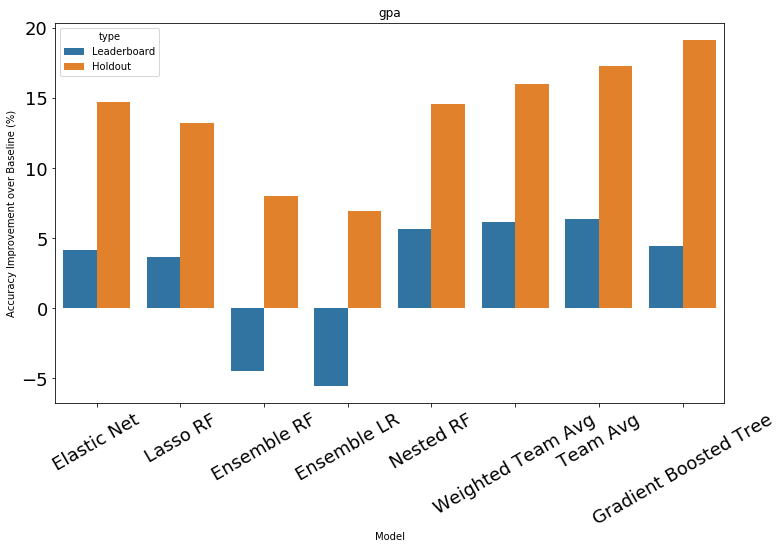

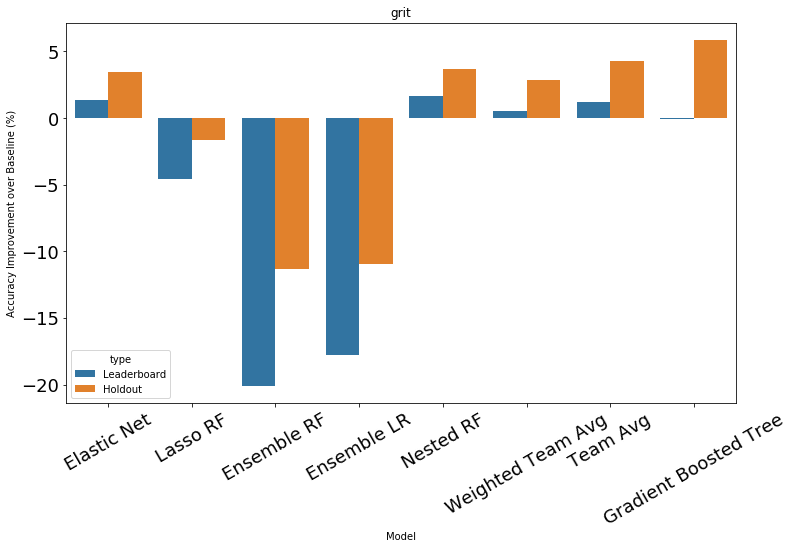

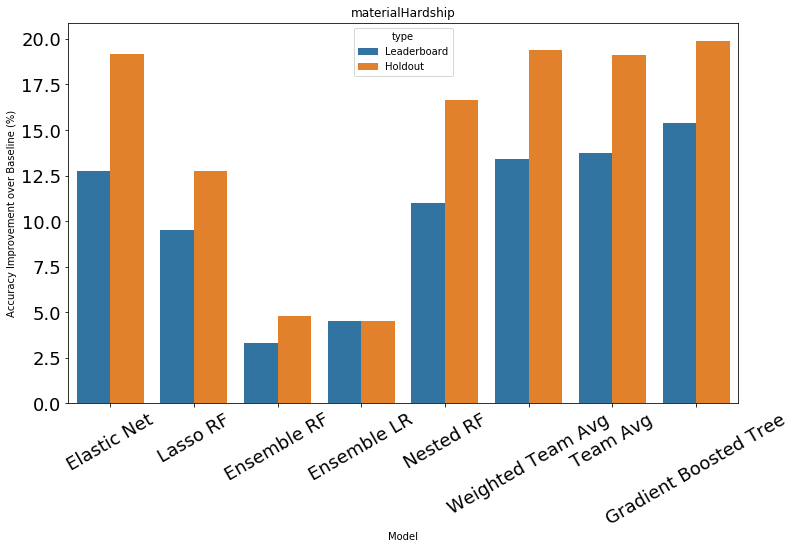

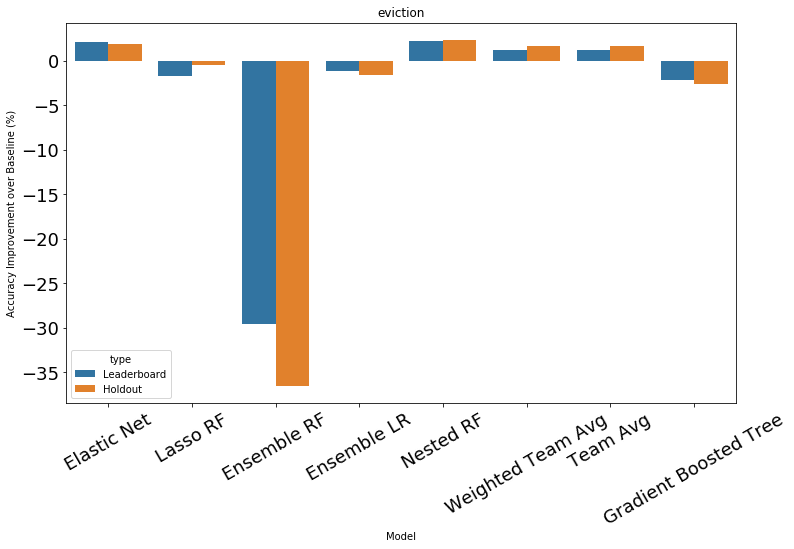

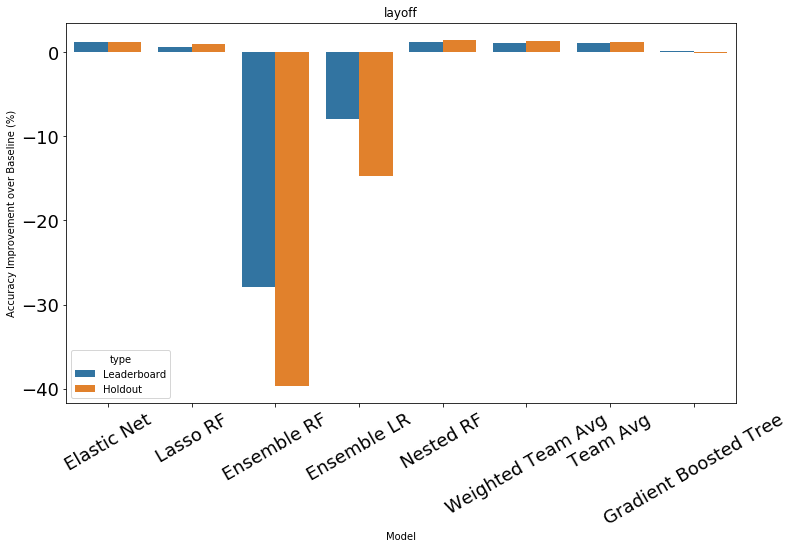

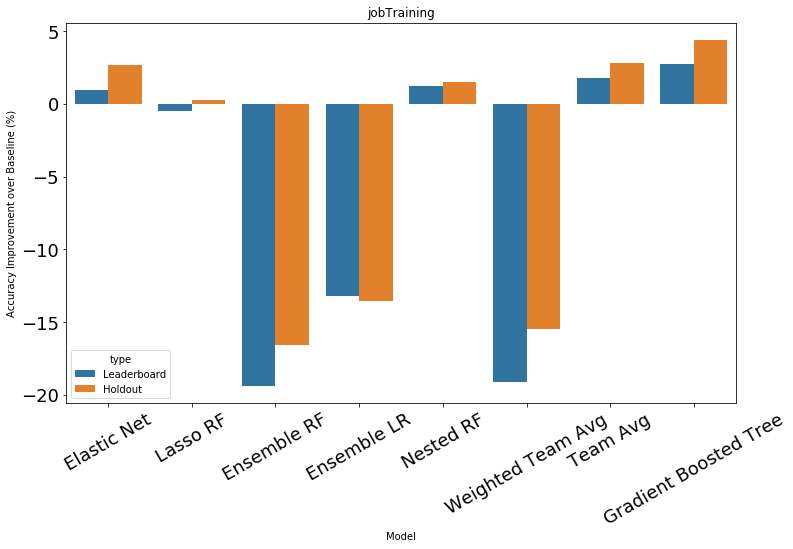

In [22]:
scores = scores_all.loc[scores_all.type != 'In-Sample Error']
for OUTCOME in training.columns.values:
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True)

    temp=scores.loc[scores.outcome==OUTCOME]
    temp.score_avg.loc[temp.type=='Leaderboard']=(1-np.divide(temp.score_avg.loc[temp.type=='Leaderboard'],BL_LB.score_avg.loc[BL_LB.outcome==OUTCOME]))*100
    temp.score_avg.loc[temp.type=='Holdout']=(1-np.divide(temp.score_avg.loc[temp.type=='Holdout'],BL_HO.score_avg.loc[BL_HO.outcome==OUTCOME]))*100
    
    
    scores_ADJ.score_avg.loc[(scores_ADJ.outcome==OUTCOME) & (scores_ADJ.type=='Leaderboard')] = (1-np.divide(scores_ADJ.score_avg.loc[(scores_ADJ.outcome==OUTCOME) & (scores_ADJ.type=='Leaderboard')],BL_LB.score_avg.loc[BL_LB.outcome==OUTCOME]))*100
    scores_ADJ.score_avg.loc[(scores_ADJ.outcome==OUTCOME) & (scores_ADJ.type=='Holdout')] = (1-np.divide(scores_ADJ.score_avg.loc[(scores_ADJ.outcome==OUTCOME) & (scores_ADJ.type=='Holdout')],BL_HO.score_avg.loc[BL_HO.outcome==OUTCOME]))*100

    
    
    sns.barplot('model','score_avg',hue = 'type', data = temp, ci = 'sd', ax=ax)

    ax.set_title(str(OUTCOME))
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy Improvement over Baseline (%)')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
    ax.tick_params(labelsize=18)
    plt.savefig(str('../output/fig/'+OUTCOME+'.pdf'))
    bools_L = (scores.type=='Leaderboard') & (scores.outcome==OUTCOME)
    bools_H = (scores.type=='Holdout') & (scores.outcome==OUTCOME)
    print(OUTCOME)
    print('Best Leaderboard Model: ',scores.loc[(bools_L)&(scores.loc[bools_L].score_avg==max(scores.loc[bools_L].score_avg))].model)
    print('Best Holdout Model: ',scores.loc[(bools_H)&(scores.loc[bools_H].score_avg==max(scores.loc[bools_H].score_avg))].model)
    print()



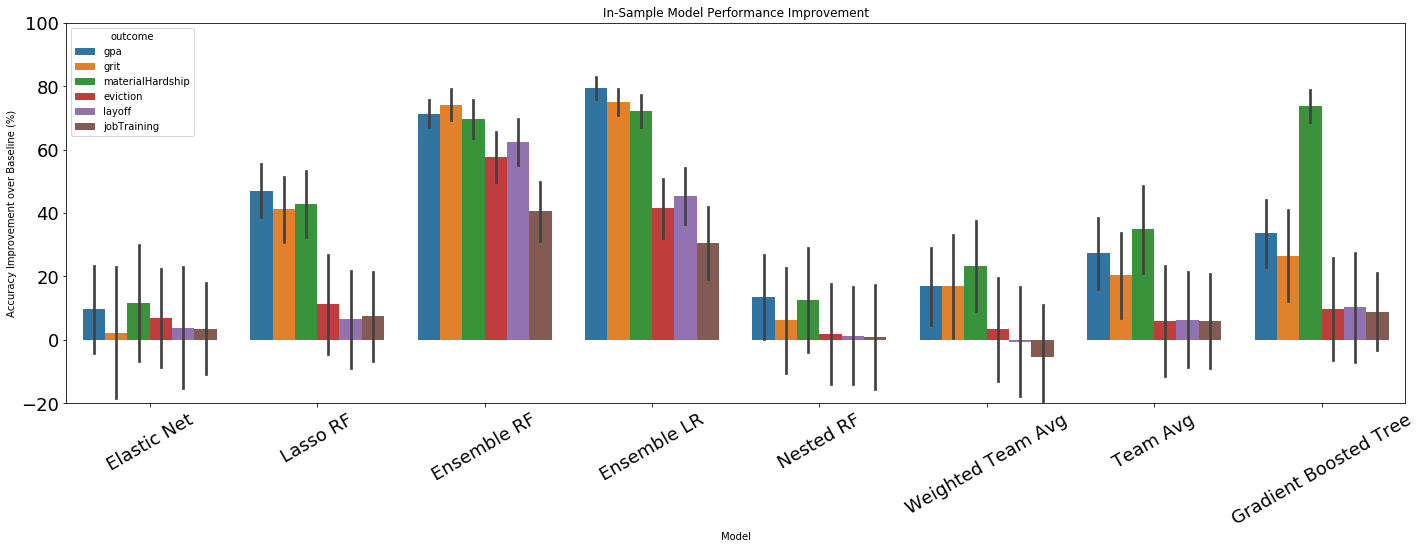

In [23]:
scores = scores_all.loc[scores_all.type=='In-Sample Error']
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 7), sharex=True)
    
sns.barplot('model','score_avg', hue = 'outcome', data = scores, ci = 'sd', ax=ax)

ax.set_title('In-Sample Model Performance Improvement')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy Improvement over Baseline (%)')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
plt.ylim([-20,100])
ax.tick_params(labelsize=18)
plt.savefig(str('../output/fig/ALL_IS.pdf'))

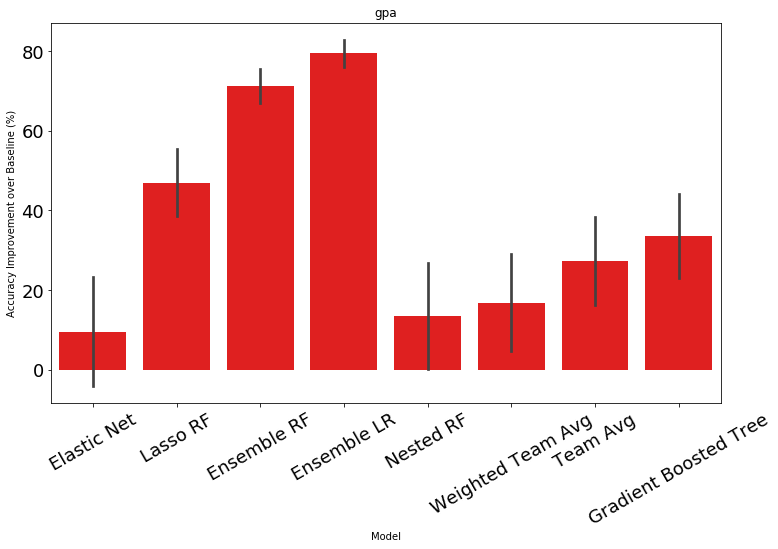

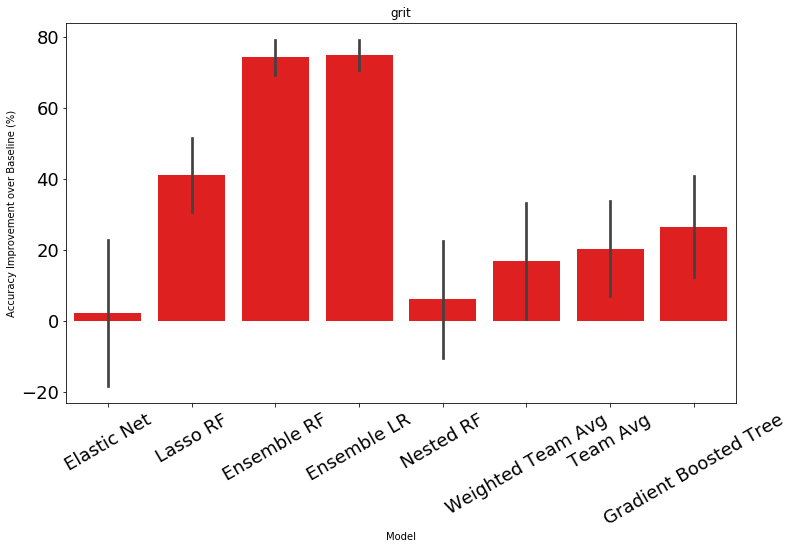

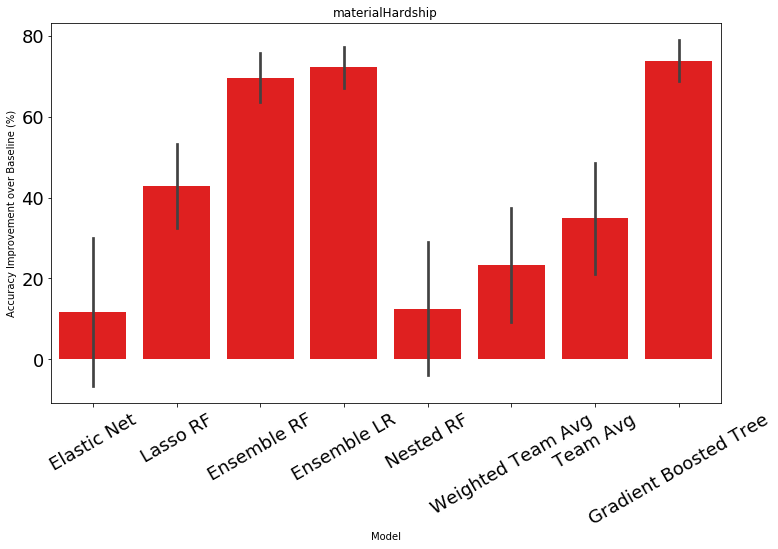

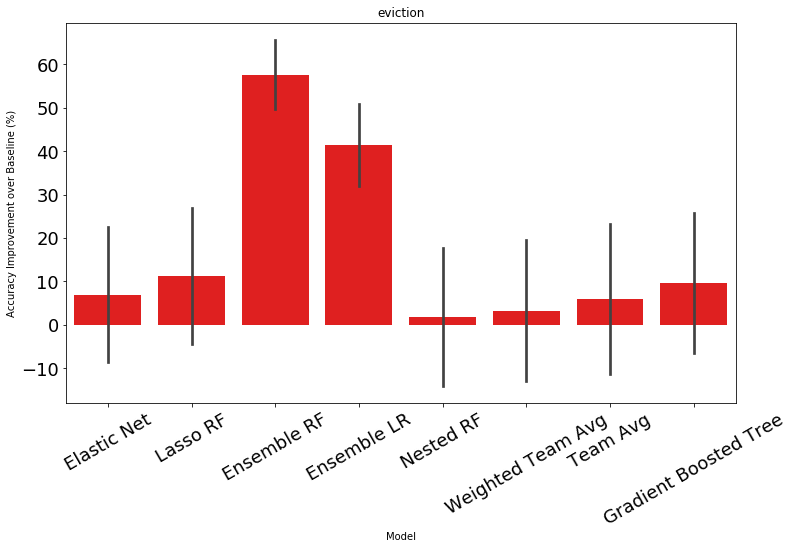

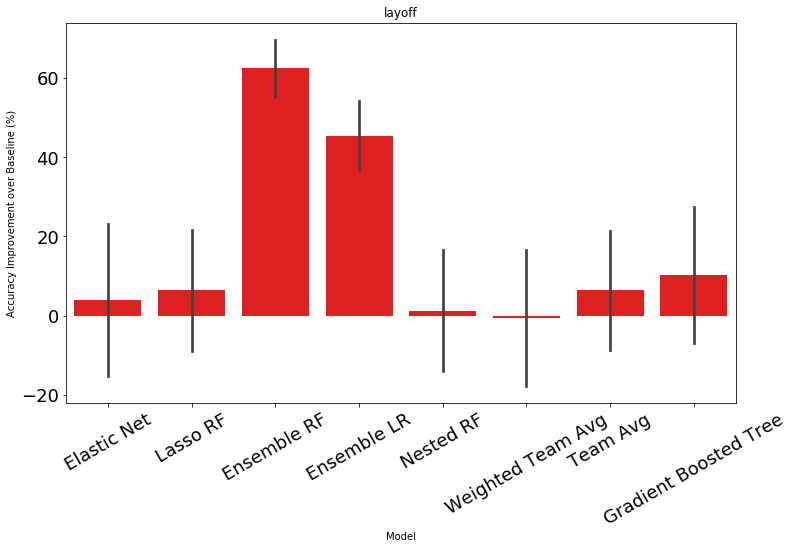

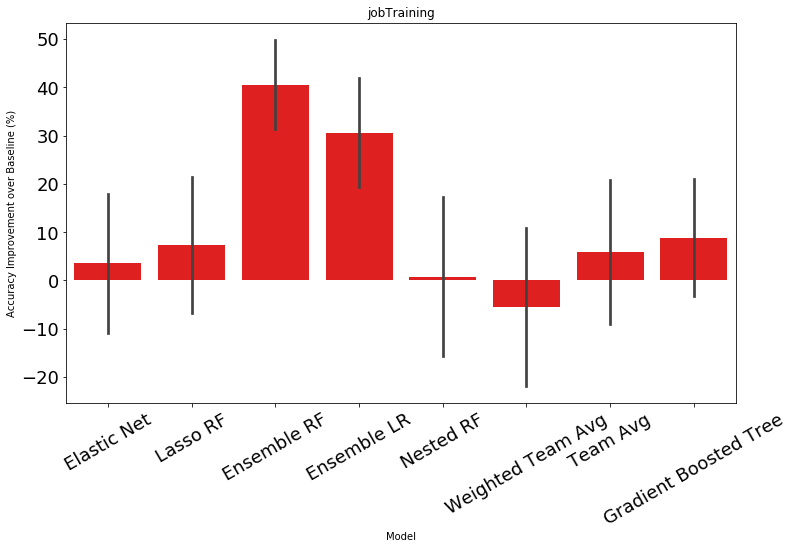

In [24]:
scores = scores_all.loc[scores_all.type=='In-Sample Error']
for OUTCOME in training.columns.values:
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True)

    temp=scores.loc[scores.outcome==OUTCOME]
    
    sns.barplot('model','score_avg', data = temp, ci = 'sd', ax=ax, color = 'red')

    ax.set_title(str(OUTCOME))
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy Improvement over Baseline (%)')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
    ax.tick_params(labelsize=18)
    plt.savefig(str('../output/fig/'+OUTCOME+'_IS.pdf'))
    bools_L = (scores.type=='Leaderboard') & (scores.outcome==OUTCOME)
    bools_H = (scores.type=='Holdout') & (scores.outcome==OUTCOME)
    



# Data Partition Performance

In [25]:
scores_PLT = scores_ADJ

scores_PLT = scores_PLT.loc[~((scores_ADJ.model=='Elastic Net') & np.in1d(scores_ADJ.outcome,['eviction','layoff','jobTraining']))]
scores_PLT['color'] = [-1]*np.shape(scores_PLT)[0]

for i,OUTCOME in enumerate(['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']):
    scores_PLT.color.loc[scores_PLT.outcome==OUTCOME] = i

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


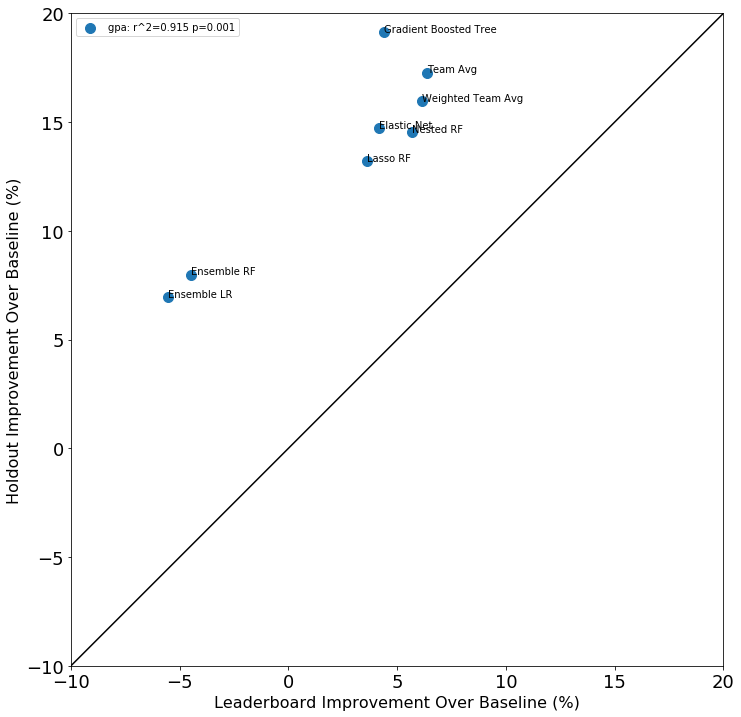

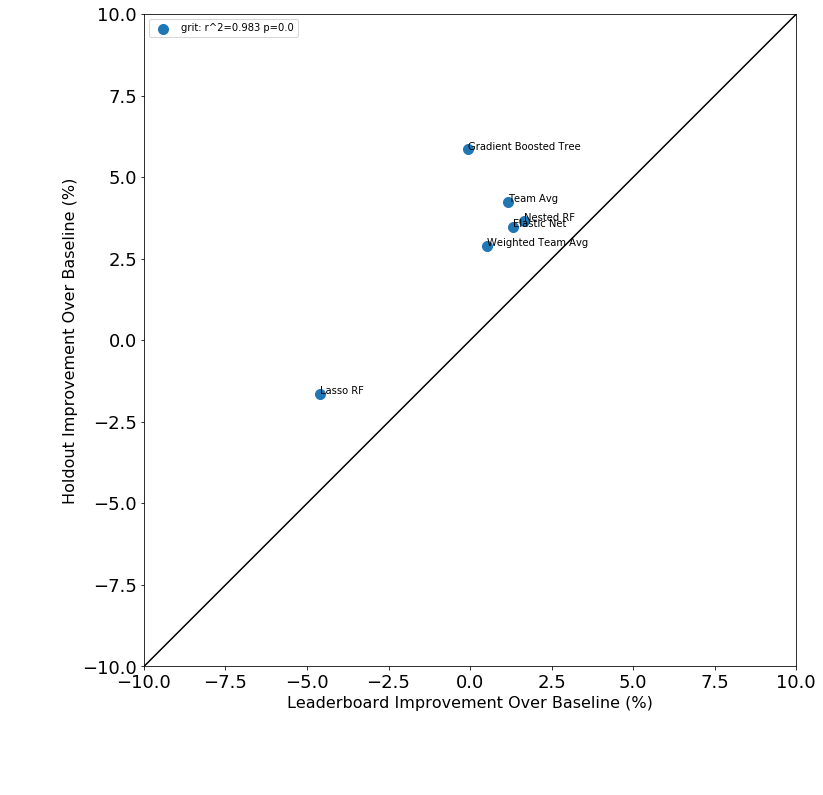

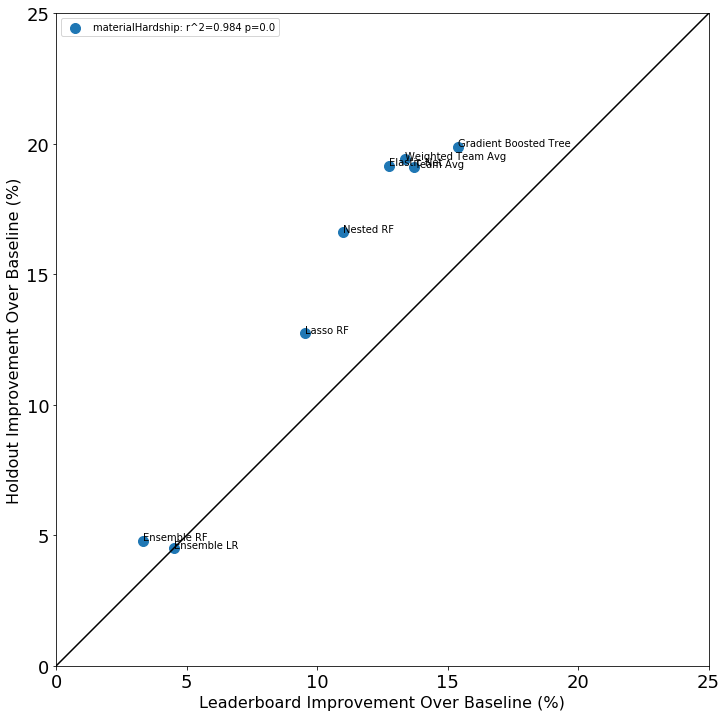

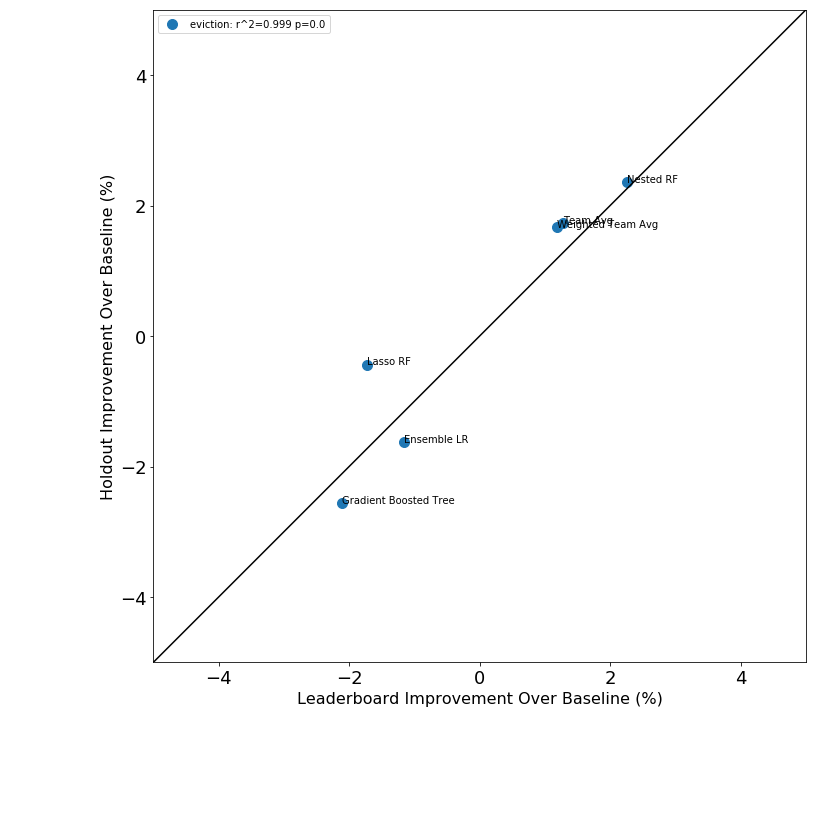

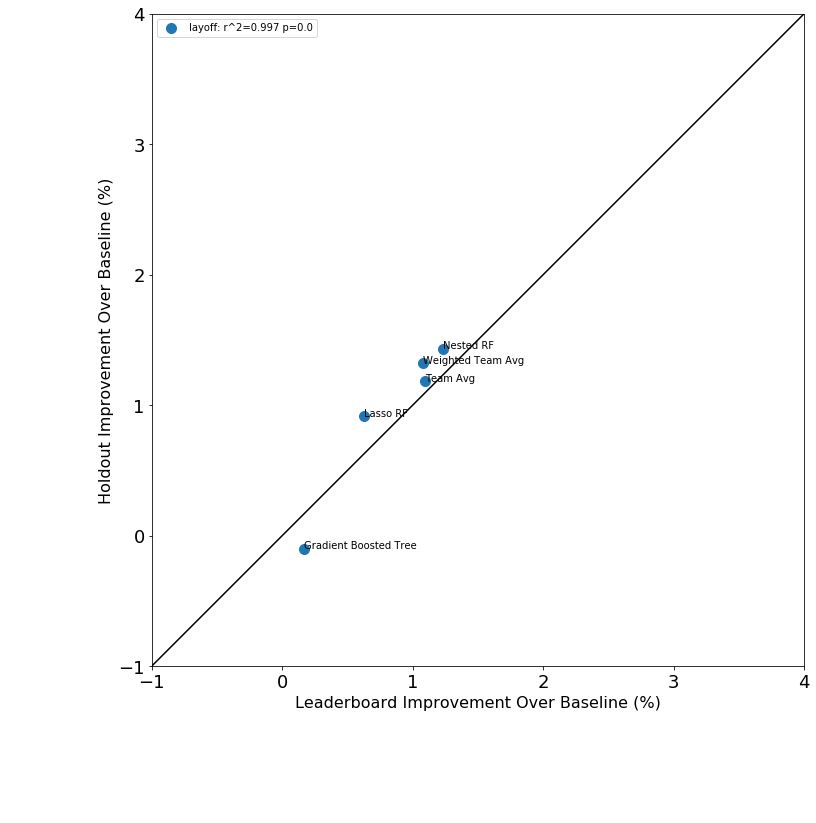

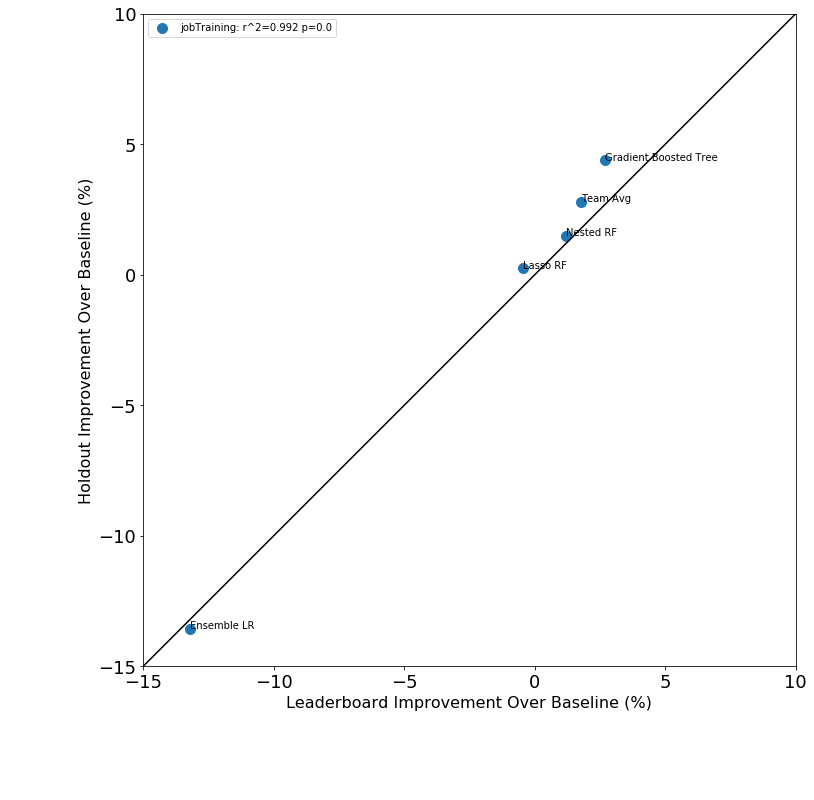

In [30]:
# LEADERBOARD vs HOLDOUT

for OC in outcomes:
    scores_X = scores_PLT.loc[(scores_PLT.type=='Leaderboard') & (scores_PLT.outcome==OC)]
    scores_Y = scores_PLT.loc[(scores_PLT.type=='Holdout') & (scores_PLT.outcome==OC)]  

    txt = [str(a) for a,b in zip(scores_X.model,scores_X.outcome)]

    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), sharex=True)
    colors = ['red','blue','green','brown','yellow','orange']
    #for i in range(1):
    corr_temp = np.round(pearsonr(scores_X.score_avg,
                                  scores_Y.score_avg),decimals = 3)
    plt.scatter(x = scores_X.score_avg, 
                s=100, y = scores_Y.score_avg,
                label=str(OC)+': r^2='+str(corr_temp[0])+' p='+str(corr_temp[1]))     
    #print(i)
    #print(len(scores_X.score_avg.loc[scores_X.color==i]),
    #      len(scores_Y.score_avg.loc[scores_Y.color==i]))
    ax.set_xlabel('Leaderboard Improvement Over Baseline (%)', size = 16)
    ax.set_ylabel('Holdout Improvement Over Baseline (%)', size = 16)
    ax.tick_params(labelsize=18)

    max_range = [min(plt.xlim()[0],plt.ylim()[0]),max(plt.xlim()[1],plt.ylim()[1])]
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylim(max_range)
    plt.xlim(max_range)
    ax.plot([-50,25],[-50,25], 'k-')
    ax.legend()
    
    if OC == 'gpa':
        plt.ylim([-10,20])
        plt.xlim([-10,20])
        
    if OC == 'grit':
        plt.ylim([-10,10])
        plt.xlim([-10,10])
    
    if OC == 'materialHardship':
        plt.ylim([-0,25])
        plt.xlim([-0,25])
        
    if OC == 'eviction':
        plt.ylim([-5,5])
        plt.xlim([-5,5]) 
        
    if OC == 'layoff':
        plt.ylim([-1,4])
        plt.xlim([-1,4])    
        
    if OC == 'jobTraining':
        plt.ylim([-15,10])
        plt.xlim([-15,10])     
        
        
    plt.savefig(str('../output/fig/'+OC+'_LB_vs_HO_noLabels.pdf'))


    for i,n in enumerate(txt):
        ax.annotate(n,(scores_X.score_avg.iloc[i],scores_Y.score_avg.iloc[i]),
                    size = 10,textcoords='data')

    plt.savefig(str('../output/fig/'+OC+'_LB_vs_HO_Labels.pdf'))


0
8 8
1
8 8
2
8 8
3
7 7
4
7 7
5
7 7


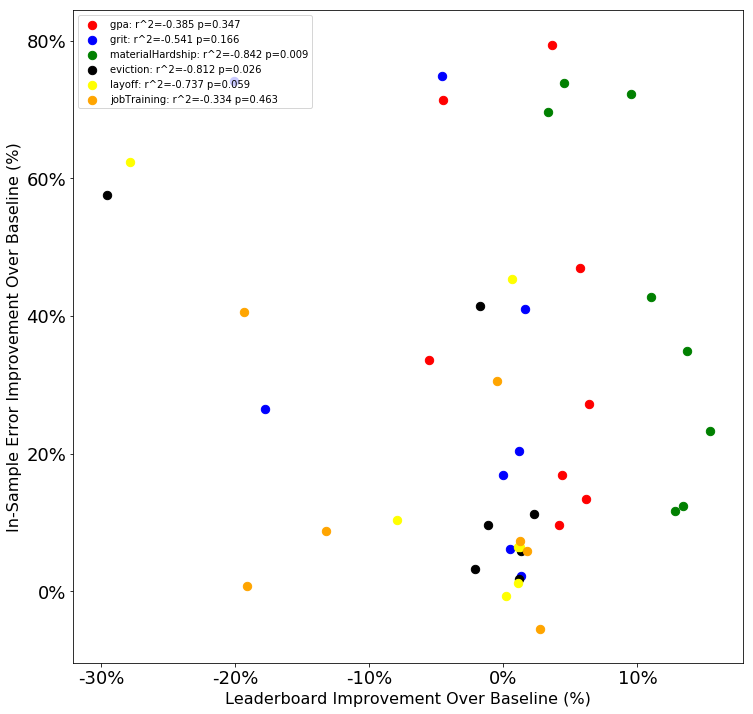

In [26]:
# LEADERBOARD VS IN-SAMPLE


scores_X = scores_PLT.loc[scores_PLT.type=='Leaderboard']
scores_Y = scores_PLT.loc[scores_PLT.type=='In-Sample Error']  
scores_Y = pd.DataFrame(scores_Y.groupby([scores_Y.model,scores_Y.outcome]).mean())


txt = [str(a) for a,b in zip(scores_X.model,scores_X.outcome)]


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), sharex=True)
colors = ['red','blue','green','black','yellow','orange']
for i in range(6):
    corr_temp = np.round(pearsonr(scores_X.score_avg.loc[scores_X.color==i],
                                  scores_Y.score_avg.loc[scores_Y.color==i]),decimals = 3)
    plt.scatter(x = scores_X.score_avg.loc[scores_X.color==i]/100, 
                s=70, y = scores_Y.score_avg.loc[scores_Y.color==i]/100,
                c = colors[i],label=str(scores_X.outcome.loc[scores_X.color==i].iloc[0])+': r^2='+str(corr_temp[0])+' p='+str(corr_temp[1]))     
    print(i)
    print(len(scores_X.score_avg.loc[scores_X.color==i]),
          len(scores_Y.score_avg.loc[scores_Y.color==i]))
ax.set_xlabel('Leaderboard Improvement Over Baseline (%)', size = 16)
ax.set_ylabel('In-Sample Error Improvement Over Baseline (%)', size = 16)
ax.tick_params(labelsize=18)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
#plt.ylim([-26, 22])
#plt.xlim([-26, 22])
#ax.plot([-26,22],[-26,22], 'k-')
ax.legend()



plt.savefig(str('../output/fig/LB_vs_IS.pdf'))



0
8 8
1
8 8
2
8 8
3
7 7
4
7 7
5
7 7


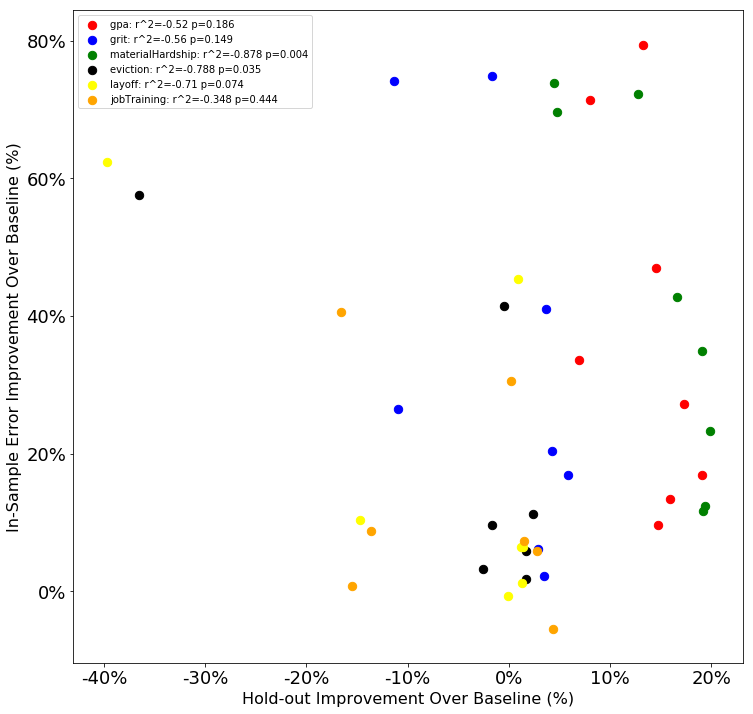

In [27]:
# HOLDOUT VS IN-SAMPLE


scores_X = scores_PLT.loc[scores_PLT.type=='Holdout']
scores_Y = scores_PLT.loc[scores_PLT.type=='In-Sample Error']  
scores_Y = scores_Y.groupby([scores_Y.model,scores_Y.outcome]).mean().reset_index()
# UNCOMMENT if STD
#scores_Y.color = [0, 1, 2, 3, 0, 1, 5, 4, 2, 3, 0, 1, 5, 4, 2, 3, 0, 1, 5, 4, 2, 3, 0,
#       1, 5, 4, 2, 3, 0, 1, 5, 4, 2, 3, 0, 1, 5, 4, 2, 3, 0, 1, 5, 4, 2]

txt = [str(a) for a,b in zip(scores_X.model,scores_X.outcome)]


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), sharex=True)
colors = ['red','blue','green','black','yellow','orange']
for i in range(6):
    corr_temp = np.round(pearsonr(scores_X.score_avg.loc[scores_X.color==i],
                                  scores_Y.score_avg.loc[scores_Y.color==i]),decimals = 3)
    plt.scatter(x = scores_X.score_avg.loc[scores_X.color==i]/100, 
                s=70, y = scores_Y.score_avg.loc[scores_Y.color==i]/100,
                c = colors[i],label=str(scores_X.outcome.loc[scores_X.color==i].iloc[0])+': r^2='+str(corr_temp[0])+' p='+str(corr_temp[1]))     
    print(i)
    print(len(scores_X.score_avg.loc[scores_X.color==i]),
          len(scores_Y.score_avg.loc[scores_Y.color==i]))
ax.set_xlabel('Hold-out Improvement Over Baseline (%)', size = 16)
ax.set_ylabel('In-Sample Error Improvement Over Baseline (%)', size = 16)
ax.tick_params(labelsize=18)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
#plt.ylim([-26, 22])
#plt.xlim([-26, 22])
#ax.plot([-26,22],[-26,22], 'k-')
ax.legend()


#for i,n in enumerate(txt):
#    ax.annotate(n,(scores_X.score_avg.iloc[i],scores_Y.score_avg.iloc[i]),
#                size = 10,textcoords='data')

plt.savefig(str('../output/fig/HO_vs_IS.pdf'))

### Bootstrapping Correlation Values

In [26]:
scores_ADJ = scores_all

bootnum = 10000
keys = ['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining','overall']


t1 = ['In-Sample Error']*14
temp = ['Leaderboard']*7
t1.extend(temp)
t2 = ['Leaderboard']*7
temp = ['Holdout']*14
t2.extend(temp)

all_keys_boot = ['gpa']*bootnum
temp = ['grit']*bootnum
all_keys_boot.extend(temp)
temp = ['materialHardship']*bootnum
all_keys_boot.extend(temp)
temp = ['eviction']*bootnum
all_keys_boot.extend(temp)
temp = ['layoff']*bootnum
all_keys_boot.extend(temp)
temp = ['jobTraining']*bootnum
all_keys_boot.extend(temp)
temp = ['overall']*bootnum
all_keys_boot.extend(temp)

df_full = pd.DataFrame(columns = ['T1-T2', 'condition', 'avg_corr','sd_corr'])


for [T1,T2] in [['In-Sample Error','Leaderboard'],['In-Sample Error','Holdout'],['Leaderboard','Holdout']]:

    X_type = scores_ADJ.loc[scores_ADJ.type==T1]
    Y_type = scores_ADJ.loc[scores_ADJ.type==T2]

    avg_corr = list([])

    # For Ind. Outcomes
    for OUTCOME in ['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']:
        corr = np.zeros(bootnum)

        X_OC = X_type.loc[X_type.outcome==OUTCOME]
        Y_OC = Y_type.loc[Y_type.outcome==OUTCOME]

        X_curr = X_OC.groupby(X_OC.model).score_avg.mean()
        Y_curr = Y_OC.groupby(Y_OC.model).score_avg.mean()


        for i in range(bootnum):
            index = np.random.choice(list(range(len(X_curr))),len(X_curr))
            avg_corr.append(pearsonr(X_curr[index].values,Y_curr[index].values)[0])

    # For Overall
    X_curr = X_type.groupby([X_type.model,X_type.outcome]).score_avg.mean()
    Y_curr = Y_type.groupby([Y_type.model,Y_type.outcome]).score_avg.mean()
    corr = np.zeros(bootnum)

    for i in range(bootnum):
        index = np.random.choice(list(range(len(X_curr))),len(X_curr))
        avg_corr.append(pearsonr(X_curr[index].values,Y_curr[index].values)[0])

    to_add = pd.DataFrame({'T1-T2':7*bootnum*[str(T1)+' w/ '+str(T2)], 'condition': all_keys_boot,
                       'avg_corr':avg_corr})
    
    df_full = df_full.append(to_add)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


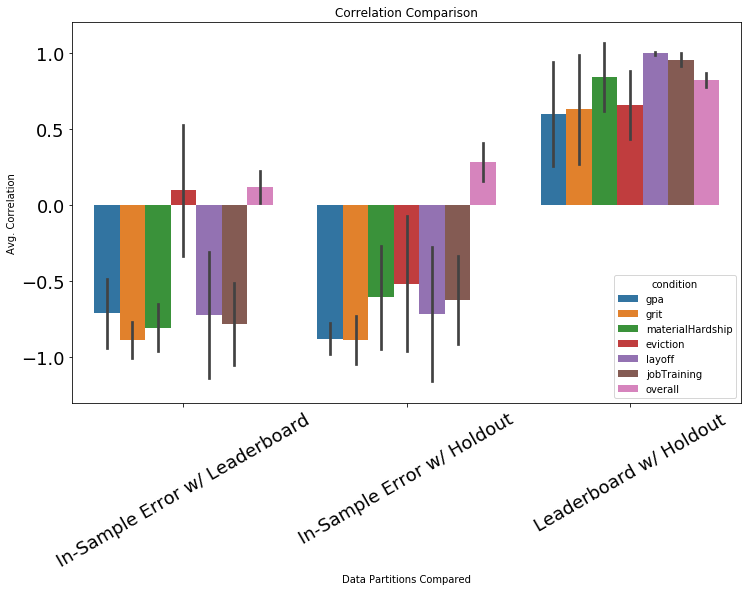

In [27]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True)
    
sns.barplot('T1-T2','avg_corr', hue = 'condition', data = df_full, ci = 'sd', ax=ax)

ax.set_title('Correlation Comparison')
ax.set_xlabel('Data Partitions Compared')
ax.set_ylabel('Avg. Correlation')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
plt.ylim([-1.3,1.2])
ax.tick_params(labelsize=18)
plt.savefig(str('../output/fig/Correlation_Comparison.pdf'))


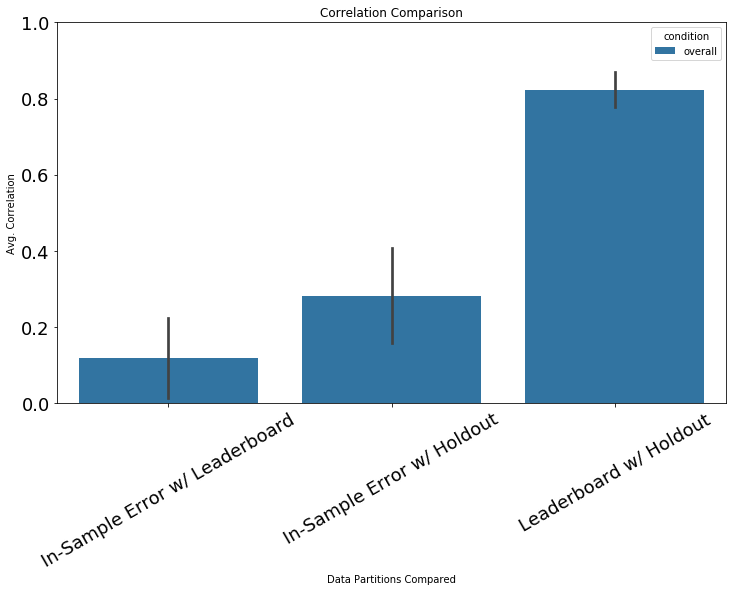

In [28]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True)
    
sns.barplot('T1-T2','avg_corr', hue = 'condition', data = df_full.loc[df_full.condition=='overall'], ci = 'sd', ax=ax)

ax.set_title('Correlation Comparison')
ax.set_xlabel('Data Partitions Compared')
ax.set_ylabel('Avg. Correlation')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
plt.ylim([0,1])
ax.tick_params(labelsize=18)
plt.savefig(str('../output/fig/Correlations_Overall.pdf'))

## Feature Importance XGBoost

In [69]:
when_csv = pd.read_csv("../output/7_fi_wave.csv")
when_csv = when_csv.iloc[:5,:]
when_csv['wave'] = ['Wave '+str(int(i)) for i in when_csv.wave.tolist()]

when_csv

,wave,gpa,eviction,grit,materialHardship,jobTraining,layoff
0,Wave 1,0.109809,0.048110,0.101655,0.317289,0.046823,0.104027
1,Wave 2,0.126548,0.085911,0.125296,0.122613,0.117057,0.073826
2,Wave 3,0.189823,0.206186,0.173252,0.162496,0.143813,0.271812
3,Wave 4,0.172079,0.230241,0.205336,0.166826,0.217391,0.241611
4,Wave 5,0.388015,0.422680,0.380277,0.214458,0.471572,0.302013


In [73]:
who_csv = pd.read_csv("../output/7_fi_who.csv")
who_csv['characteristic'] = ['Father','Home Visit','Child', 'Kindergarten', 'Mother', 'Other','Caregiver','Teacher']

who_csv

,who,gpa,eviction,grit,materialHardship,jobTraining,layoff,characteristic
0,f,0.199531,0.140893,0.221547,0.192397,0.130435,0.271812,Father
1,hv,0.203214,0.209622,0.189125,0.112950,0.036789,0.187919,Home Visit
2,k,0.044861,0.003436,0.082405,0.015725,0.006689,0.023490,Child
3,kind,0.003348,0.003436,0.008105,0.008432,0.003344,0.006711,Kindergarten
4,m,0.350184,0.515464,0.360351,0.570217,0.668896,0.395973,Mother
5,o,0.016070,0.017182,0.003377,0.009800,0.006689,0.016779,Other
6,p,0.085370,0.048110,0.105708,0.060714,0.140468,0.080537,Caregiver
7,t,0.087379,0.058419,0.023303,0.023064,0.006689,0.016779,Teacher


In [74]:
father = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Father'],'score': 6*[0]})

homevisit = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Home Visit'],'score': 6*[0]})

child = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Child'],'score': 6*[0]})

kinder = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Kindergarten'],'score': 6*[0]})

mother = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Mother'],'score': 6*[0]})

other = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Other'],'score': 6*[0]})

care = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Caregiver'],'score': 6*[0]})

teacher = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Teacher'],'score': 6*[0]})


wav1 = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Wave 1'],'score': 6*[0]})

wav2 = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Wave 2'],'score': 6*[0]})

wav3 = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Wave 3'],'score': 6*[0]})

wav4 = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Wave 4'],'score': 6*[0]})

wav5 = pd.DataFrame({'outcome': ['gpa','eviction','grit','materialHardship','jobTraining','layoff'],
          'characteristic': 6*['Wave 5'],'score': 6*[0]})


who_df = pd.concat([mother,father,care,homevisit,child,teacher,kinder,other],ignore_index = True)
when_df = pd.concat([wav1,wav2,wav3,wav4,wav5],ignore_index = True)

In [75]:
for i in range(len(who_df)):
    OC = who_df.iloc[i].outcome
    Char = who_df.iloc[i].characteristic
    
    who_df.loc[i,"score"] = who_csv.loc[who_csv.characteristic==Char].loc[:,OC].values


    

In [76]:
for i in range(len(when_df)):
    OC = when_df.iloc[i].outcome
    Char = when_df.iloc[i].characteristic
    
    when_df.loc[i,"score"] = when_csv.loc[when_csv.wave==Char].loc[:,OC].values




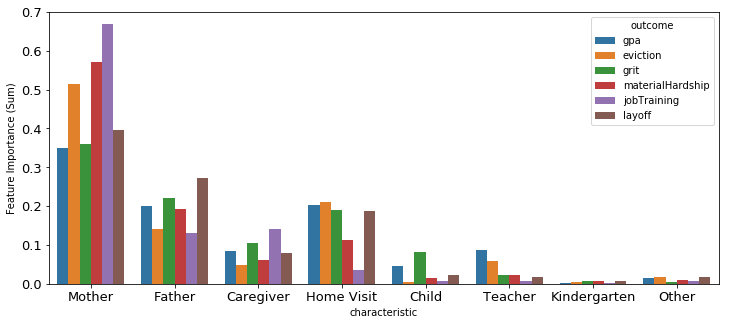

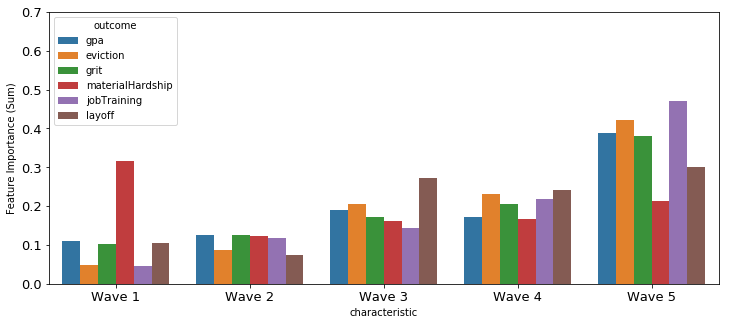

In [77]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharex=True)

sns.barplot('characteristic','score', hue = 'outcome', data = who_df,
            ci = None,ax=ax)

ax.set_ylabel('Feature Importance (Sum)')
ax.tick_params(labelsize=13)
ax.set_ylim(0,0.7)
plt.savefig('../output/fig/Who_Feature_Importance.pdf')


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharex=True)

sns.barplot('characteristic','score', hue = 'outcome', data = when_df,
            ci = None,ax=ax)

ax.set_ylabel('Feature Importance (Sum)')
ax.tick_params(labelsize=13)
ax.set_ylim(0,0.7)
plt.savefig('../output/fig/When_Feature_Importance.pdf')